In [1]:
%matplotlib inline
#
from lrgsglib.core import *
#
move_to_rootf()
plt.style.use('ipynb/nb_plotsheet.mplstyle')
#
path_suppinf = PATHPLOT / Path(PATHNPAPR, 'suppinf')

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


### Ising XERR

In [2]:
side = 96
geo = 'sqr'
pflip = 0.25

In [3]:
l = Lattice2D(side, geo, pflip=pflip, init_nw_dict=True)
l.flip_sel_edges(l.nwDict['randXERR']['G'])
l.compute_k_eigvV(10)

In [4]:
isdy = IsingDynamics(l, T=0.5, ic=f'ground_state_2', runlang='C3', rndStr=True, out_suffix='gs_2')
isdy.init_ising_dynamics()
l.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.run(thrmSTEP=50)

In [5]:
ene = np.fromfile(Path(l.isingpath) / Path(f"ene_p={pflip:.3g}_T=0.5_gs_2.bin"))

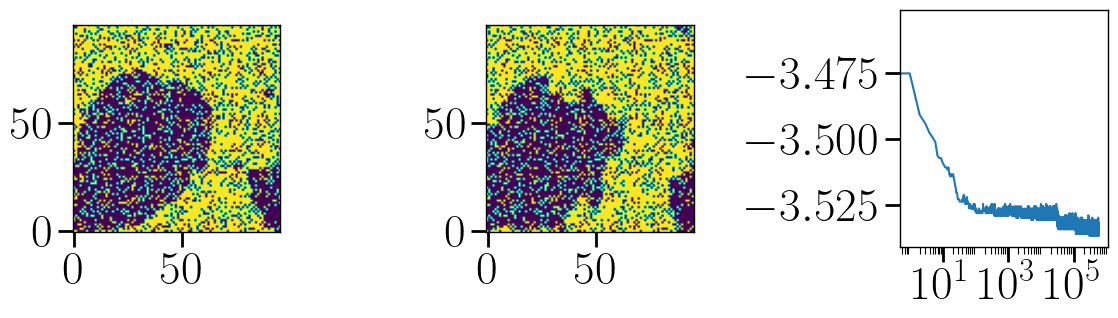

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(l.get_eigV_bin_check(2).reshape(*l.syshape))
ax2.imshow(isdy.s.reshape(*l.syshape))
ax3.plot(ene, '-')
ax3.set_xscale('log')
# ax3.xaxis.set_major_locator(plt.MaxNLocator(nbins=3, prune=None))
ax3.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4))
ax3.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
fig.tight_layout()

## Topological Symmetry Breaking

In [19]:
side = 64
geo = 'sqr'
pflip = 0.1
navg = 10

In [20]:
spect = []

In [21]:
for _ in range(navg):
    l = Lattice2D(side, geo=geo, pflip=pflip)
    l.flip_random_fract_edges()
    l.compute_full_laplacian_spectrum()
    spect.extend(l.eigv)

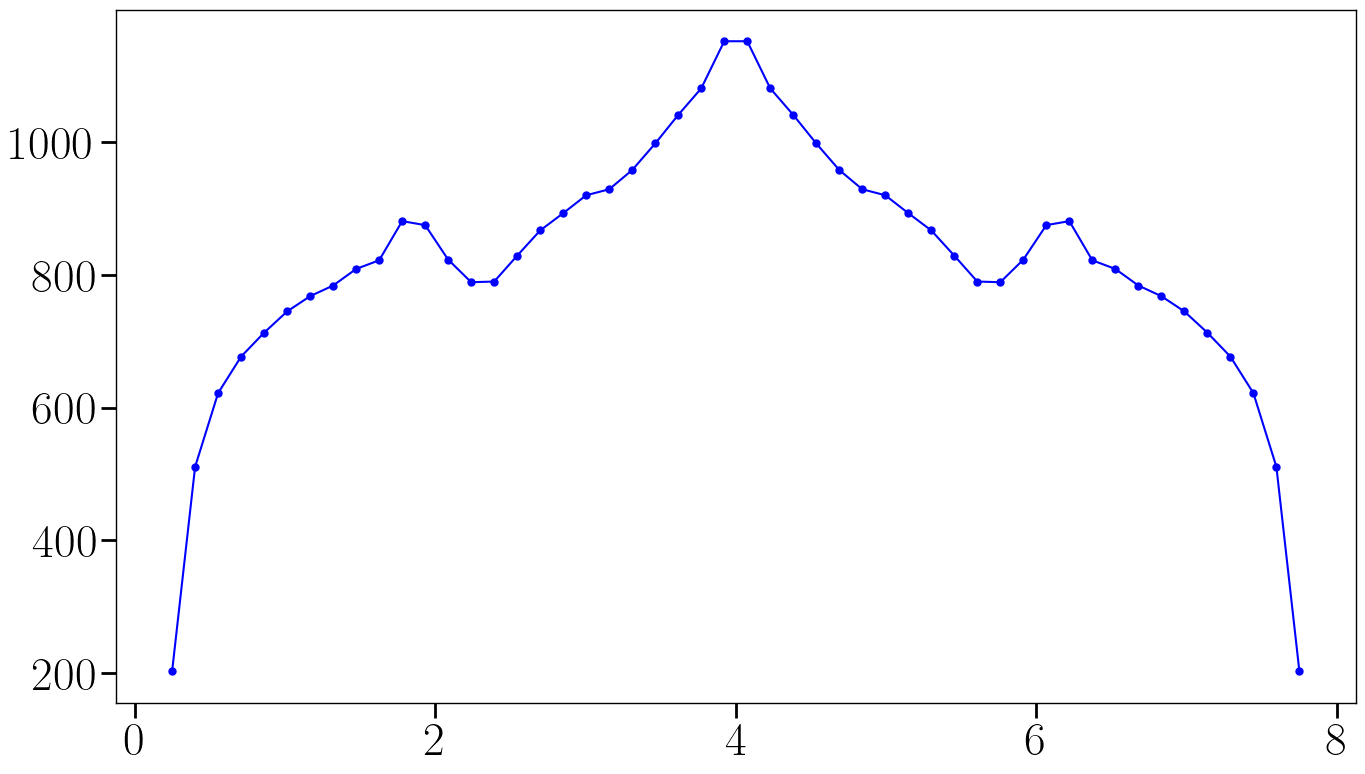

In [22]:
counts, bin_edges = np.histogram(spect, bins=50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, counts, marker='o', linestyle='-', color='b')

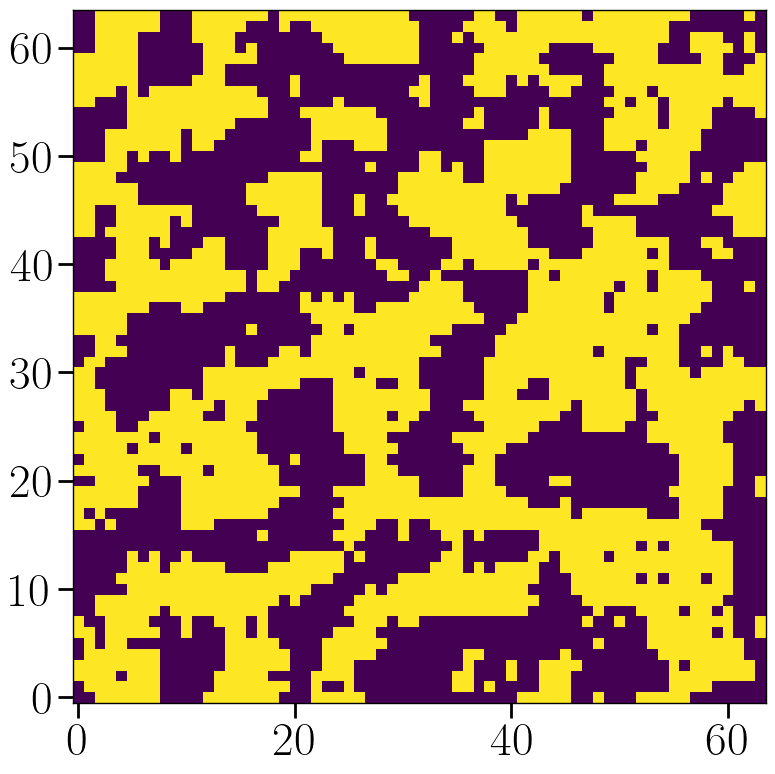

In [38]:
plt.imshow(np.sign(l.eigV[-4000].reshape(*l.syshape)))